In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [2]:
degree = 2
n_nodes = 8
rate = 1.5
T = 50
dt = 0.5
fprefix = 'data/rrg_sis_'
train_sample = 50000
val_sample = 10000


In [3]:
# Generating the network
graph = nx.random_regular_graph(degree, n_nodes)
#graph = nx.barabasi_albert_graph(n_nodes, 3)
nx.write_edgelist(graph, fprefix + 'edgelist.b')
    
# Generating the dataset
transform = [dl.SIS_StateToFloat()]
dataset = dl.SISDataset(rate)
dataset.generate(graph, train_sample, T, init_active=0.01, dt=dt, pre_transform=transform)

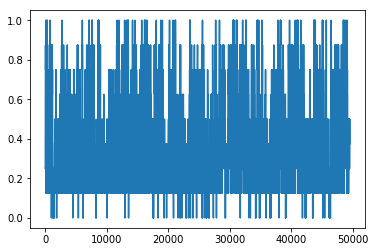

In [4]:
def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg
avg = show_train_dataset(dataset)
plt.plot(avg)
plt.show()

In [5]:
n_hidden = [128, 64]
n_embedding = n_nodes
keepprob = 0.9
lr = 1e-2
wd = 1e-3
optimizer = lambda p: torch.optim.Adam(p, lr=lr, weight_decay=wd)
loss = torch.nn.BCELoss(reduction='none')
use_cuda = torch.cuda.is_available()

model = dl.basicMarkovCompleteVAE(graph, n_hidden, n_embedding,
                                  keepprob=keepprob, optimizer=optimizer,
                                  use_cuda=use_cuda)

In [6]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - val_sample, val_sample])

In [17]:
lr /= 5
for g in model.optimizer.param_groups:
    g['lr'] = lr
    

In [18]:
model.fit(train_dataset,
          val_dataset=val_dataset,
          epochs=20,
          batch_size=128,
          verbose=True,
          keep_best=True,
          training_metrics=['loss', 'recon', 'kl_div'],
          model_metrics=['lr'],
          show_var=False,
          beta=1)

Epoch: 111 - Time: 4.99 - lr: 8e-05
Epoch: 112 - Time: 5.01 - lr: 8e-05
Epoch: 113 - Time: 5.12 - lr: 8e-05
Epoch: 114 - Time: 6.03 - lr: 8e-05
Epoch: 115 - Time: 5.64 - lr: 8e-05
Epoch: 116 - Time: 5.43 - lr: 8e-05
Epoch: 117 - Time: 5.38 - lr: 8e-05
Epoch: 118 - Time: 5.34 - lr: 8e-05
Epoch: 119 - Time: 5.34 - lr: 8e-05
New best Epoch: 120 - Time: 5.50 - lr: 8e-05
	 Train. - loss: 0.1357, recon: 0.0007, kl_div: 0.1350, 
	 Val. - loss: 0.1366, recon: 0.0006, kl_div: 0.1360, 
Epoch: 121 - Time: 5.21 - lr: 8e-05
Epoch: 122 - Time: 6.12 - lr: 8e-05
Epoch: 123 - Time: 5.43 - lr: 8e-05
Epoch: 124 - Time: 5.35 - lr: 8e-05
Epoch: 125 - Time: 5.49 - lr: 8e-05
Epoch: 126 - Time: 5.77 - lr: 8e-05
Epoch: 127 - Time: 5.13 - lr: 8e-05
Epoch: 128 - Time: 5.26 - lr: 8e-05
Epoch: 129 - Time: 5.69 - lr: 8e-05
Epoch: 130 - Time: 5.49 - lr: 8e-05


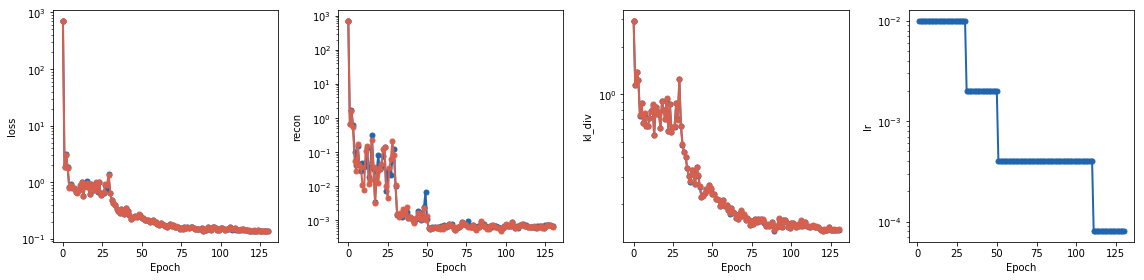

In [19]:
fig, ax = plt.subplots(1, 4,figsize=(16, 4))
_ax = {}
metrics = ['loss', 'recon', 'kl_div', 'lr']
for i, m in enumerate(metrics):
#     ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    _ax[m] = ax[i]

model.history.plot(training_metrics = ['loss', 'recon', 'kl_div'], model_metrics=['lr'],ax=(fig,_ax))
plt.tight_layout()
plt.show()

In [32]:
def test_model(learned_model, dataset):
    init_states = dataset[0][1]
    t = 0
    states, z, past_states = learned_model.predict(init_states, batch_size=2)    
    learned_avg = [np.mean(states)]
    
    while(t < T):
        t += dt
        states, z, past_states = learned_model.predict(past_states, batch_size=2)
        states = states[0]
        learned_avg.append(np.mean(states))
        states = torch.bernoulli(torch.tensor(states))
        past_states = states
    
    return learned_avg

def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg

def show_dataset(dataset):
    avg = []
    t = 0
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt,
                                    filename=None,
                                    full_data_mode=False,
                                    overwrite=True)
    while t < T:
        t += dt
        sisnet.update(record=False)
        avg_state, std_state = sisnet.get_avg_activity()
        avg.append(avg_state['I'])
    return avg


In [33]:
null_model = dl.basicMarkovCompleteVAE(graph, n_hidden, n_embedding, keepprob=1, optimizer=optimizer, loss=loss, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
trained_ts = test_model(model, dataset)
untrained_ts = test_model(null_model, dataset)


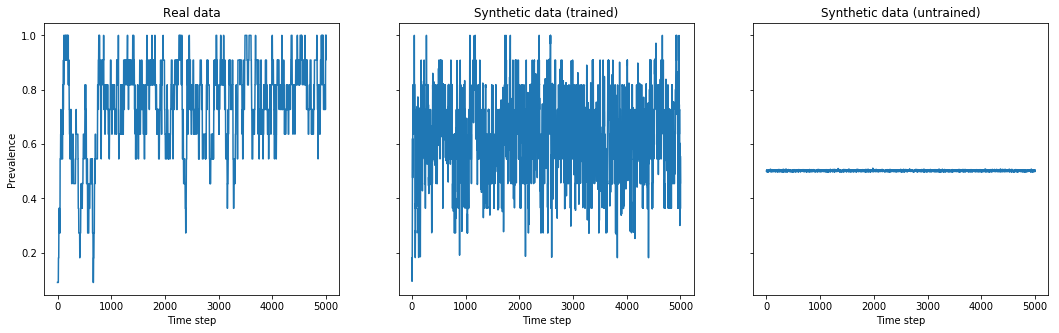

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True,sharey=True)

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

ax[1].plot(trained_ts)
ax[1].set_title('Synthetic data (trained)')
ax[1].set_xlabel('Time step')

ax[2].plot(untrained_ts)
ax[2].set_title('Synthetic data (untrained)')
ax[2].set_xlabel('Time step')

figname = "naivemodel_evol_rrgsis_d{0}_n{1}_rate{2}".format(degree, n_nodes, rate)
#fig.savefig("fig/png/" + figname + ".png")
#fig.savefig("fig/pdf/" + figname + ".pdf")
plt.show()

In [20]:
def reconstruct_TS(graph, model, dataset, T, dt):
    transform = [dl.SIS_StateToFloat()]
    t = 0
    past = dataset[0][0].numpy()
    real_ts = []
    learned_ts = []
    while(t < T):
        t += dt
        real_prob = dataset.get_transition_probability(graph, past, dt)
        real_ts.append(real_prob)
        past = torch.tensor(past).float()
        learned_prob, _, _ = model.predict(past, batch_size=128)
        learned_ts.append(np.mean(learned_prob, 0))
        past = torch.bernoulli(torch.tensor(real_prob)).numpy()
    
    return np.array(real_ts), np.array(learned_ts)
        
        
        


In [21]:
real, learned = reconstruct_TS(graph, model, dataset, 50, dt)
print(real.shape, learned.shape)
real_TS, learned_TS = np.mean(real, 1), np.mean(learned, 1)
print(real_TS.shape, learned_TS.shape)

(100, 8) (100, 8)
(100,) (100,)


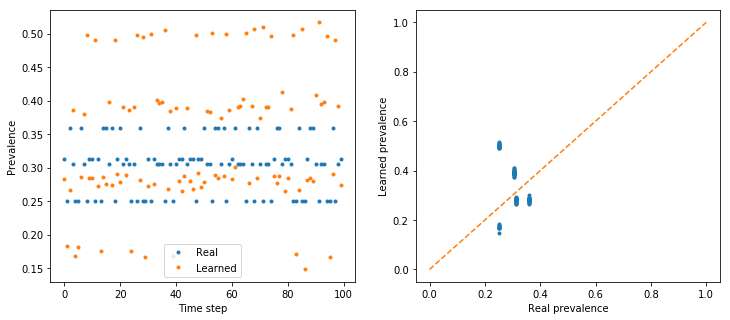

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(real_TS, '.', label='Real')
ax[0].plot(learned_TS, '.', label='Learned')
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Prevalence')
ax[0].legend()

ax[1].plot(real_TS, learned_TS, '.')
ax[1].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')
ax[1].set_xlabel('Real prevalence')
ax[1].set_ylabel('Learned prevalence')
plt.show()

In [23]:
all_states = dataset.enumerate_all_states(graph)
markovProb = np.zeros([len(all_states), len(all_states)])

for i, past in enumerate(all_states):
    prob = dataset.get_transition_probability(graph, past, dt)
    for j, present in enumerate(all_states):
        present_prob = present * prob + (1 - present) * (1 - prob)
        markovProb[i, j] = np.prod(present_prob)
markovProb /= np.sum(markovProb, 0)


In [24]:
learnedProb = np.zeros([len(all_states), len(all_states)])
for i, past in enumerate(all_states):
    _past = torch.tensor(past).float()
    prob, _, _ = model.predict(_past, batch_size=2)
    avg_prob = np.mean(prob, 0)
    for j, present in enumerate(all_states):
        present_prob = present * avg_prob + (1 - present) * (1 - avg_prob)
        learnedProb[i, j] = np.prod(present_prob)
learnedProb /= np.sum(learnedProb, 0)


/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


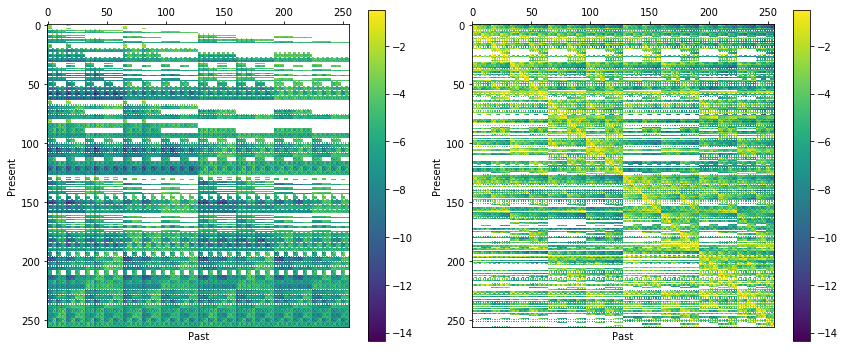

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cs = ax[0].imshow(np.log(markovProb), origin='upper')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Past')
ax[0].set_ylabel('Present')
plt.colorbar(cs, ax=ax[0])

ax[1].imshow(np.log(learnedProb), origin='upper')
ax[1].xaxis.tick_top()
ax[1].set_xlabel('Past')
ax[1].set_ylabel('Present')
plt.colorbar(cs, ax=ax[1])
plt.tight_layout()

figname = "naivemodel_trans_rrgsis_d{0}_n{1}_rate{2}_dt{3}".format(degree, n_nodes, rate, dt)
fig.savefig("fig/png/" + figname + ".png")
fig.savefig("fig/pdf/" + figname + ".pdf")

plt.show()

In [65]:
realTransitionProb = np.array([])
for s in dataset:
    past = s[1].numpy()
    realTransitionProb = np.append(realTransitionProb, dataset.get_transition_probability(graph, past, dt))

learnedTransitionProb = np.array([[]])
for s in dataset:
    past = s[1]
    prob, _, _ = model.predict(past, batch_size=128)
#     print(prob)
    prob = np.mean(prob, 0)
    learnedTransitionProb = np.append(learnedTransitionProb, prob)

In [ ]:
dataset[0]

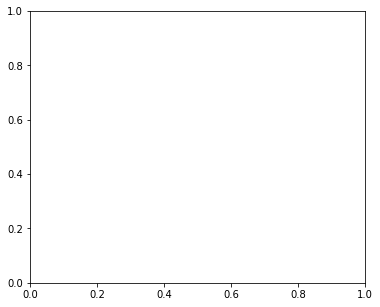

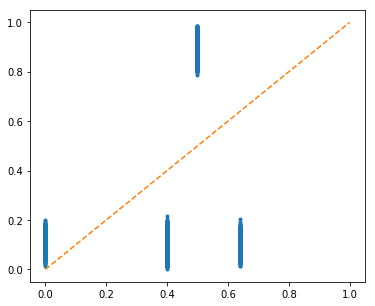

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(realTransitionProb, learnedTransitionProb, '.')
ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')
plt.show()